# Quantium Virtual Internship - Retail Strategy and Analytics - Task 2

We need to evaluate the performance of a store trial that occured in stores 77, 86 and 88.

To do this, we will choose control store whose performance we will compare to the trial stores to see if there are significant inreases in store performance.

In [102]:
# Load packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as sns

# Load data
qvi_data = pd.read_csv('data/QVI_data.csv')
qvi_data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Calculating Monthly Measures

To select the control stores, we will compute monthly statistics for each store and choose control stores to be those whose statistics correlates best with each of the trial stores.

First, we compute a variety of monthly store metrics.

In [5]:
# Measure calculations to be used during analysis

qvi_data['MONTH'] = pd.PeriodIndex(qvi_data['DATE'], freq='M').to_timestamp()

columns = ['MONTH', 'STORE_NBR', 'LYLTY_CARD_NBR', 'PROD_QTY', 'TOT_SALES']

# Total sales
monthly_sales = qvi_data[columns].groupby(columns[:2])['TOT_SALES'].sum().reset_index()

# Number of customers
monthly_cnt = qvi_data[columns].groupby(columns[:2])['LYLTY_CARD_NBR'].count().reset_index()
monthly_cnt.rename(columns={'LYLTY_CARD_NBR':'NUM_CUSTS'}, inplace=True)

# Average transactions per customer
monthly_cust_avg = qvi_data[columns].groupby(columns[:3])['PROD_QTY'].count().groupby(columns[:2]).mean().reset_index()
monthly_cust_avg.rename(columns={'PROD_QTY':'AVG_TRNS'}, inplace=True)

# Average number of packets bought per customer
monthly_chips_avg = qvi_data[columns].groupby(columns[:3])['PROD_QTY'].sum().groupby(columns[:2]).mean().reset_index()
monthly_chips_avg.rename(columns={'PROD_QTY':'AVG_CHIPS'})

# Average price per unit
qvi_data['PRICE_PER_UNIT'] = qvi_data['TOT_SALES'] / qvi_data['PROD_QTY']
monthly_ppu = qvi_data.groupby(columns[:2])['PRICE_PER_UNIT'].mean().reset_index()
monthly_ppu.rename(columns={"PRICE_PER_UNIT":"AVG_PPU"})

to_merge = [monthly_sales, monthly_cnt, monthly_cust_avg, monthly_chips_avg, monthly_ppu]
monthly_data = monthly_sales
for df in to_merge[1:]:
    monthly_data = monthly_data.merge(df, on=columns[:2])

monthly_data.head()


We will only consider stores with full observation periods. Then, we further filter out data from the pre-trial period, which will be used to determine the control stores.

In [7]:
has_full_obs = monthly_data.groupby('STORE_NBR')['MONTH'].count() == 12
stores_with_full_obs = [store for store in has_full_obs.index if has_full_obs[store]]

pretrial_df = monthly_data[(monthly_data['STORE_NBR'].isin(stores_with_full_obs)) & (monthly_data['MONTH'] < '2019-02-01')]
pretrial_df.head()


,MONTH,STORE_NBR,TOT_SALES,NUM_CUSTS,AVG_TRNS,PROD_QTY,PRICE_PER_UNIT
0,2018-07-01,1,206.9,52,1.061224,1.265306,3.384615
1,2018-07-01,2,150.8,41,1.051282,1.179487,3.239024
2,2018-07-01,3,1205.7,138,1.232143,2.419643,4.451449
3,2018-07-01,4,1399.9,160,1.250000,2.484375,4.405625
4,2018-07-01,5,812.0,120,1.290323,2.580645,3.383333


## Selecting Control Stores

We calculate both the Pearson correlation and magnitude distance between the trial stores and each other store.

In [8]:
def store_correlation(monthly_data, metric_col, storeX, storeY):
    storeX_array = monthly_data[monthly_data['STORE_NBR'] == storeX][metric_col]
    storeY_array = monthly_data[monthly_data['STORE_NBR'] == storeY][metric_col]
    return sp.pearsonr(storeX_array, storeY_array)[0]

def calculate_correlation_table(pretrial_df, trial_store):
    corr_df = pd.DataFrame()
    corr_df['Control'] = pretrial_df['STORE_NBR'].unique()
    corr_df['Trial Store'] = trial_store

    for metric in pretrial_df.columns[2:]:
        if metric != "AVG_TRNS":
            col_name = metric + '_COR'
            corr_df[col_name] = corr_df['Control'].apply(lambda x : store_correlation(pretrial_df, metric, x, trial_store))

    return corr_df

trial_stores = [77, 86, 88]
correlation_table = pd.concat([calculate_correlation_table(pretrial_df, trial_store) for trial_store in trial_stores])

# Remove rows where control is a trial store
correlation_table = correlation_table[~correlation_table['Control'].isin(trial_stores)]

correlation_table.head()

,Control,Trial Store,TOT_SALES_COR,NUM_CUSTS_COR,PROD_QTY_COR,PRICE_PER_UNIT_COR
0,1,77,0.075218,0.355839,-0.791857,-0.851944
1,2,77,-0.263079,-0.379313,-0.034676,0.178421
2,3,77,0.806644,0.861748,0.316541,-0.089079
3,4,77,-0.263300,-0.181233,-0.146667,-0.412672
4,5,77,-0.110652,0.434760,0.318414,0.136721


In [9]:
def calculate_dist(pretrial_df, metric_col, storeX, storeY):
    arrayX = np.array(monthly_data[monthly_data['STORE_NBR'] == storeX][metric_col])
    arrayY = np.array(monthly_data[monthly_data['STORE_NBR'] == storeY][metric_col])
    dist = np.abs(arrayX - arrayY)
    return np.mean(1 - (dist - np.min(dist))/(np.max(dist) - np.min(dist)))
    #return 1 - (np.mean(dist) - np.min(dist)) / (np.max(dist) - np.min(dist))

def calculate_dist_table(pretrial_df, trial_store):
    dist_df = pd.DataFrame()
    dist_df['Control'] = pretrial_df['STORE_NBR'].unique()
    dist_df['Trial Store'] = trial_store
    for metric in pretrial_df.columns[2:]:
        col_name = metric + '_DIST'
        dist_df[col_name] = dist_df['Control'].apply(lambda x : calculate_dist(pretrial_df, metric, x, trial_store))

    return dist_df

trial_stores = [77, 86, 88]
dist_table = pd.concat([calculate_dist_table(pretrial_df, trial_store) for trial_store in trial_stores])

# Remove rows where control is a trial store
dist_table = dist_table[~dist_table['Control'].isin(trial_stores)]

dist_table.head()


,Control,Trial Store,TOT_SALES_DIST,NUM_CUSTS_DIST,AVG_TRNS_DIST,PROD_QTY_DIST,PRICE_PER_UNIT_DIST
0,1,77,0.343210,0.725490,0.653718,0.568265,0.517284
1,2,77,0.547271,0.517857,0.749035,0.487811,0.552543
2,3,77,0.487141,0.492188,0.537680,0.480010,0.530014
3,4,77,0.525581,0.501157,0.440281,0.678465,0.540804
4,5,77,0.494214,0.430233,0.319630,0.489252,0.591946


We will use monthly total sales and total number of customers to determine how similar two stores are.

To do this, we use the average of each of the similarity statistics.

In [10]:
# Merge correlation and distance tables and use average of scores to get final score for the control
metrics = ['TOT_SALES', 'NUM_CUSTS']

comparison_df = correlation_table[['Control', 'Trial Store','TOT_SALES_COR', 'NUM_CUSTS_COR']].merge(
    dist_table[['Control', 'Trial Store','TOT_SALES_DIST', 'NUM_CUSTS_DIST']],
    on = ['Control', 'Trial Store']
)

comparison_df['Score'] = comparison_df.iloc[:, 2:6].mean(axis=1)

comparison_df.head()

,Control,Trial Store,TOT_SALES_COR,NUM_CUSTS_COR,TOT_SALES_DIST,NUM_CUSTS_DIST,Score
0,1,77,0.075218,0.355839,0.343210,0.725490,0.374939
1,2,77,-0.263079,-0.379313,0.547271,0.517857,0.105684
2,3,77,0.806644,0.861748,0.487141,0.492188,0.661930
3,4,77,-0.263300,-0.181233,0.525581,0.501157,0.145552
4,5,77,-0.110652,0.434760,0.494214,0.430233,0.312139


The control stores are then chosen as those with the highest score:

In [11]:
max_scores = comparison_df.groupby('Trial Store')['Score'].max().reset_index()
controls = max_scores.merge(comparison_df[['Control', 'Score']], how='inner', on='Score')

controls

,Trial Store,Score,Control
0,77,0.830999,233
1,86,0.770207,138
2,88,0.790257,134


So the controls for 77, 86, and 88 will be 233, 138, and 134, respectively.

Next, we will visually confirm that these are indeed similar.

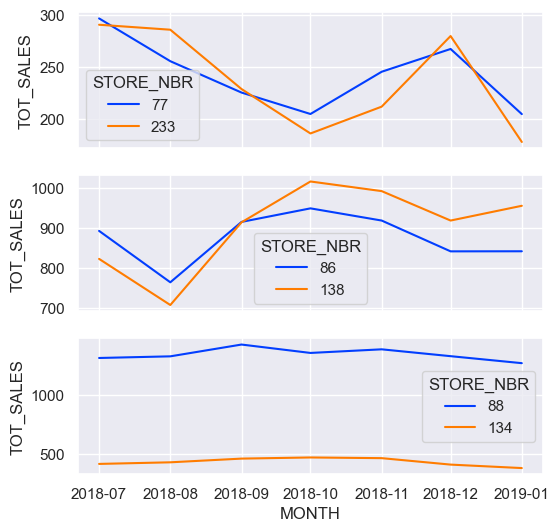

In [12]:
sns.set_theme()

comps = [[77,233], [86, 138], [88, 134]]

def plot_controls(metric):
    fig, ax = plt.subplots(3, 1, figsize=(6,6), sharex=True)

    for i in range(3):
        sns.lineplot(
            data = pretrial_df[pretrial_df['STORE_NBR'].isin(comps[i])],
            x='MONTH', y=metric,
            hue='STORE_NBR',
            palette='bright',
            ax=ax[i]
        )
plot_controls('TOT_SALES')

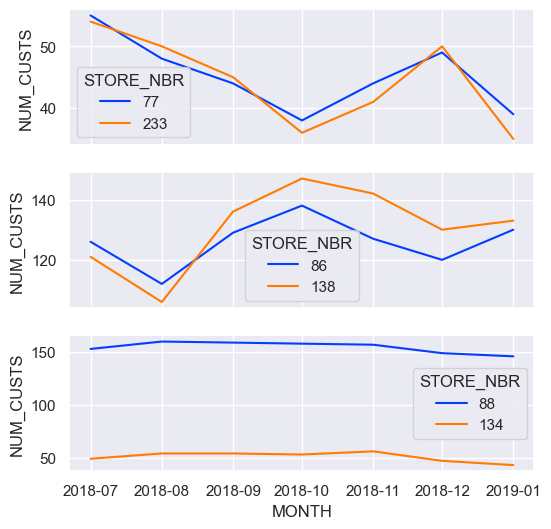

In [13]:
plot_controls('NUM_CUSTS')

Indeed there appears to be a strong correlation between the control stores and trial stores.

## Trial Assessment

In [66]:
trial_store1, trial_store2, trial_store3 = 77, 86, 88
control_store1, control_store2, control_store3 = 233, 138, 134

To account for differences between the trial store and its control, we will scale the control measures to match the trial store.

We then calculate the percentage difference and calculate a t-score to tell us if there is a statistically significant increase during the trial months.

Since there are 8 months in the pre-trial period, the number of degrees of freedom is 8-1=7.

In [83]:
def compare_tot_sales(trial_store, control_store):
    scaling_factor = pretrial_df[pretrial_df['STORE_NBR'] == trial_store]['TOT_SALES'].sum() / \
        pretrial_df[pretrial_df['STORE_NBR'] == control_store]['TOT_SALES'].sum()

    trial_store_sales = monthly_data[monthly_data['STORE_NBR'] == trial_store][['MONTH','TOT_SALES']].rename(columns={'TOT_SALES':'trial_sales'})
    control_sales = monthly_data[monthly_data['STORE_NBR'] == control_store][['MONTH','TOT_SALES']].rename(columns={'TOT_SALES':'control_sales'})
    trial_store_sales = trial_store_sales.merge(control_sales, on='MONTH')
    trial_store_sales['scaled_control_sales'] = scaling_factor * trial_store_sales['control_sales']
    trial_store_sales['percentage_diff'] = 100*(trial_store_sales['trial_sales'] - trial_store_sales['scaled_control_sales'])/trial_store_sales['scaled_control_sales']

    std_dev = np.std(trial_store_sales[trial_store_sales['MONTH'] < '2019-02-01']['percentage_diff'])
    trial_store_sales['t_value'] = (trial_store_sales['percentage_diff'] - np.mean(trial_store_sales['percentage_diff'])) / std_dev

    return trial_store_sales

trial_store_sales = compare_tot_sales(trial_store1, control_store1)
trial_store_sales

,MONTH,trial_sales,control_sales,scaled_control_sales,percentage_diff,t_value
0,2018-07-01,296.8,290.7,297.565550,-0.257271,-0.976103
1,2018-08-01,255.5,285.9,292.652187,-12.694997,-2.325110
2,2018-09-01,225.2,228.6,233.998916,-3.760238,-1.356038
3,2018-10-01,204.5,185.7,190.085733,7.583035,-0.125737
4,2018-11-01,245.3,211.6,216.597421,13.251579,0.489078
5,2018-12-01,267.3,279.8,286.408121,-6.671641,-1.671812
6,2019-01-01,204.4,177.5,181.692071,12.498029,0.407347
7,2019-02-01,235.0,244.0,249.762622,-5.910661,-1.589275
8,2019-03-01,278.5,199.1,203.802205,36.652103,3.027119
9,2019-04-01,263.5,158.6,162.345704,62.307960,5.809776


The t-statistic for March and April is significantly higher than the 95th percentile value of the T-distribution, so the increase in sales is statistically significant in these months.
Let's visualise this:

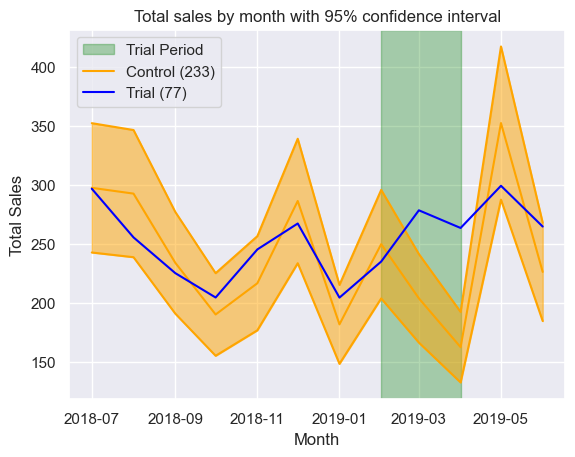

In [84]:
def graph_tot_sales(trial_store_sales, trial_store, control_store):
    std_dev = np.std(trial_store_sales[trial_store_sales['MONTH'] < '2019-02-01']['percentage_diff'])
    trial_store_sales['percentile_95'] = trial_store_sales['scaled_control_sales']*(1 + 2*std_dev/100)
    trial_store_sales['percentile_05'] = trial_store_sales['scaled_control_sales']*(1 - 2*std_dev/100)

    fig, ax = plt.subplots()

    ax.axvspan(xmin = pd.to_datetime('2019-02-01'),
            xmax = pd.to_datetime('2019-04-01'),
            ymin = 0, 
            ymax = 1,
            color='green',
            alpha=0.3,
            label="Trial Period"
    )
    sns.lineplot(
        data = trial_store_sales,
        x = 'MONTH', y='scaled_control_sales',
        label = "Control (" + str(control_store) + ")",
        color='orange'
    )
    sns.lineplot(
        data = trial_store_sales,
        x = 'MONTH', y='percentile_95',
        color='orange'
    )
    pc5 = sns.lineplot(
        data = trial_store_sales,
        x = 'MONTH', y='percentile_05',
        color='orange'
    )
    sns.lineplot(
        data = trial_store_sales,
        x = 'MONTH', y='trial_sales',
        label = "Trial (" + str(trial_store) + ")",
        color='blue'
    )

    line = pc5.get_lines()
    plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='orange', alpha=.5)

    ax.set_ylabel("Total Sales")
    ax.set_xlabel("Month")
    ax.set_title("Total sales by month with 95% confidence interval")

graph_tot_sales(trial_store_sales, trial_store1, control_store1)

Now we will do the same with the number of customers, to see if this increased significantly during the trial period.

In [93]:
def compare_num_custs(trial_store, control_store):
    scaling_factor = pretrial_df[pretrial_df['STORE_NBR'] == trial_store]['NUM_CUSTS'].sum() / \
        pretrial_df[pretrial_df['STORE_NBR'] == control_store]['NUM_CUSTS'].sum()

    trial_num_custs = monthly_data[monthly_data['STORE_NBR'] == trial_store][['MONTH','NUM_CUSTS']].rename(columns={'NUM_CUSTS':'trial_num_custs'})
    control_num_custs = monthly_data[monthly_data['STORE_NBR'] == control_store][['MONTH','NUM_CUSTS']].rename(columns={'NUM_CUSTS':'control_num_custs'})
    trial_num_custs = trial_num_custs.merge(control_num_custs, on='MONTH')
    trial_num_custs['scaled_control_num_custs'] = scaling_factor * trial_num_custs['control_num_custs']
    trial_num_custs['percentage_diff'] = 100*(trial_num_custs['trial_num_custs'] - trial_num_custs['scaled_control_num_custs'])/trial_num_custs['scaled_control_num_custs']

    std_dev = np.std(trial_num_custs[trial_num_custs['MONTH'] < '2019-02-01']['percentage_diff'])
    trial_num_custs['t_value'] = (trial_num_custs['percentage_diff'] - np.mean(trial_num_custs['percentage_diff'])) / std_dev

    return trial_num_custs

trial_num_custs = compare_num_custs(trial_store1, control_store1)
trial_num_custs

,MONTH,trial_num_custs,control_num_custs,scaled_control_num_custs,percentage_diff,t_value
0,2018-07-01,55,54,55.041801,-0.075943,-1.001300
1,2018-08-01,48,50,50.964630,-5.817035,-2.103119
2,2018-09-01,44,45,45.868167,-4.072906,-1.768389
3,2018-10-01,38,36,36.694534,3.557659,-0.303945
4,2018-11-01,44,41,41.790997,5.285835,0.027723
5,2018-12-01,49,50,50.964630,-3.854890,-1.726548
6,2019-01-01,39,35,35.675241,9.319513,0.801859
7,2019-02-01,45,47,47.906752,-6.067521,-2.151192
8,2019-03-01,55,41,41.790997,31.607294,5.079289
9,2019-04-01,48,33,33.636656,42.701463,7.208461


As before, the number of customers has a statistically significant increase in the latter two months of the trial.

We can visualise this in the same way as before:

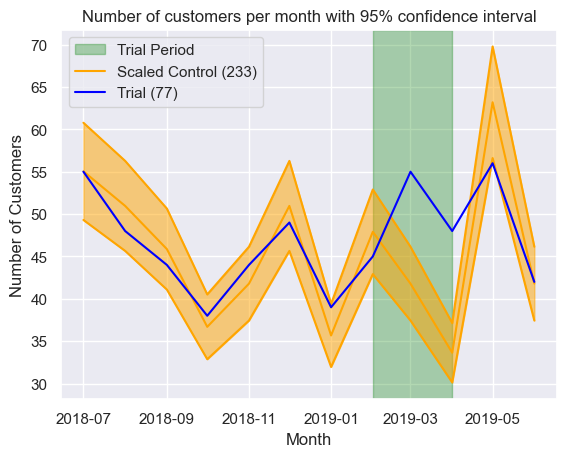

In [94]:
def graph_num_custs(trial_num_custs, trial_store, control_store):
    std_dev = np.std(trial_num_custs[trial_num_custs['MONTH'] < '2019-02-01']['percentage_diff'])
    trial_num_custs['percentile_95'] = trial_num_custs['scaled_control_num_custs']*(1 + 2*std_dev/100)
    trial_num_custs['percentile_05'] = trial_num_custs['scaled_control_num_custs']*(1 - 2*std_dev/100)

    fig, ax = plt.subplots()

    ax.axvspan(xmin = pd.to_datetime('2019-02-01'),
            xmax = pd.to_datetime('2019-04-01'),
            ymin = 0, 
            ymax = 1,
            color='green',
            alpha=0.3,
            label="Trial Period"
    )
    sns.lineplot(
        data = trial_num_custs,
        x = 'MONTH', y='scaled_control_num_custs',
        label = "Scaled Control (" + str(control_store) + ")",
        color='orange'
    )
    sns.lineplot(
        data = trial_num_custs,
        x = 'MONTH', y='percentile_95',
        color='orange'
    )
    pc5 = sns.lineplot(
        data = trial_num_custs,
        x = 'MONTH', y='percentile_05',
        color='orange'
    )
    sns.lineplot(
        data = trial_num_custs,
        x = 'MONTH', y='trial_num_custs',
        label = "Trial (" + str(trial_store) + ")",
        color='blue'
    )

    line = pc5.get_lines()
    plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='orange', alpha=.5)

    ax.set_ylabel("Number of Customers")
    ax.set_xlabel("Month")
    ax.set_title("Number of customers per month with 95% confidence interval")

graph_num_custs(trial_num_custs, trial_store1, control_store1)

Now we want to perform the same procedure for the other two trial stores and their control.

In [40]:
trial_store_sales2 = compare_tot_sales(trial_store2, control_store2)

trial_store_sales2

,MONTH,trial_sales,control_sales,scaled_control_sales,percentage_diff,t_value
0,2018-07-01,892.20,822.4,795.977327,12.088620,1.174582
1,2018-08-01,764.05,707.4,684.672132,11.593559,1.111285
2,2018-09-01,914.60,913.6,884.247186,3.432616,0.067850
3,2018-10-01,948.40,1015.4,982.776481,-3.497894,-0.818265
4,2018-11-01,918.00,991.4,959.547571,-4.329913,-0.924644
5,2018-12-01,841.20,918.0,888.505820,-5.324199,-1.051771
6,2019-01-01,841.40,954.8,924.123483,-8.951562,-1.515555
7,2019-02-01,913.20,748.6,724.548428,26.037124,2.957997
8,2019-03-01,1026.80,940.6,910.379711,12.788102,1.264016
9,2019-04-01,848.20,834.2,807.398208,5.053491,0.275091


The t-value is too low for the trial performance to be significantly greater than the trial performance.

We can also see this in the following visual:

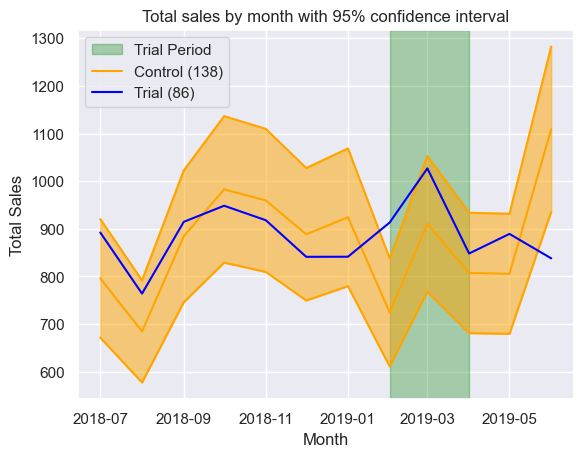

In [96]:
graph_tot_sales(trial_store_sales2, trial_store2, control_store2)

Looking now at the number of customers:

In [99]:
trial_num_custs2 = compare_num_custs(trial_store2, control_store2)
trial_num_custs2

,MONTH,trial_num_custs,control_num_custs,scaled_control_num_custs,percentage_diff,t_value
0,2018-07-01,126,121,116.636066,8.028335,1.024978
1,2018-08-01,112,106,102.177049,9.613657,1.297645
2,2018-09-01,129,136,131.095082,-1.598139,-0.630729
3,2018-10-01,138,147,141.698361,-2.610024,-0.804768
4,2018-11-01,127,142,136.878689,-7.217112,-1.597164
5,2018-12-01,120,130,125.311475,-4.238619,-1.084878
6,2019-01-01,130,133,128.203279,1.401463,-0.114812
7,2019-02-01,139,112,107.960656,28.750607,4.589107
8,2019-03-01,142,138,133.022951,6.748497,0.804852
9,2019-04-01,127,128,123.383607,2.931016,0.148264


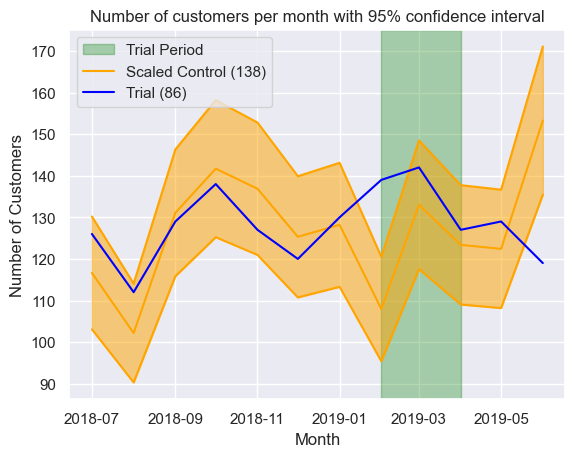

In [100]:
graph_num_custs(trial_num_custs2, trial_store2, control_store2)

So the number of customers does not significantly increase for two out of three months of the trial period.

Let's consider the final trial store.

In [101]:
trial_store_sales3 = compare_tot_sales(trial_store3, control_store3)
trial_store_sales3

,MONTH,trial_sales,control_sales,scaled_control_sales,percentage_diff,t_value
0,2018-07-01,1310.00,419.20,1287.911965,1.715027,-0.262155
1,2018-08-01,1323.80,432.65,1329.234522,-0.408846,-0.741000
2,2018-09-01,1423.00,463.80,1424.936950,-0.135932,-0.679469
3,2018-10-01,1352.40,473.40,1454.431117,-7.015191,-2.230455
4,2018-11-01,1382.80,467.60,1436.611725,-3.745739,-1.493330
5,2018-12-01,1325.20,413.40,1270.092573,4.338851,0.329408
6,2019-01-01,1266.40,384.20,1180.381148,7.287379,0.994178
7,2019-02-01,1370.20,347.60,1067.934635,28.303733,5.732490
8,2019-03-01,1477.20,388.60,1193.899308,23.729027,4.701084
9,2019-04-01,1439.40,594.60,1826.794977,-21.206265,-5.429951


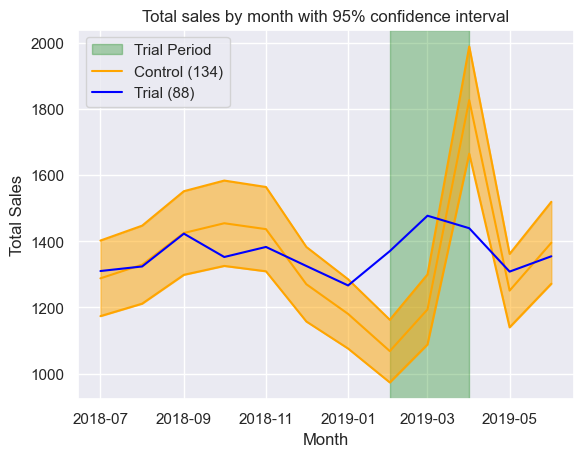

In [90]:
graph_tot_sales(trial_store_sales3, trial_store3, control_store3)

So there is a statistically significant increase for two out of the three months (but a signifant decrease in the third month).

In [79]:
trial_num_custs3 = compare_num_custs(88, 134)
trial_num_custs3

,MONTH,trial_num_custs,control_num_custs,scaled_control_num_custs,percentage_diff,t_value
0,2018-07-01,153,49,148.926966,0.027349,0.080935
1,2018-08-01,160,54,164.123596,-0.025125,-0.812569
2,2018-09-01,159,54,164.123596,-0.031218,-0.916317
3,2018-10-01,158,53,161.084270,-0.019147,-0.710779
4,2018-11-01,157,56,170.202247,-0.077568,-1.705544
5,2018-12-01,149,47,142.848315,0.043064,0.348526
6,2019-01-01,146,43,130.691011,0.117139,1.609828
7,2019-02-01,154,39,118.533708,0.299208,4.710020
8,2019-03-01,170,46,139.808989,0.215945,3.292246
9,2019-04-01,162,66,200.595506,-0.192405,-3.660925


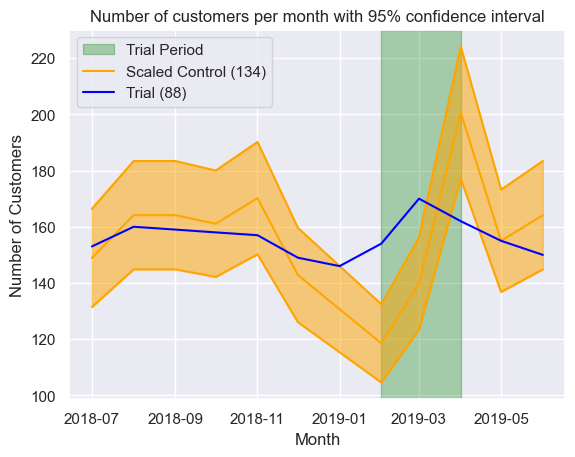

In [80]:
graph_num_custs(trial_num_custs3, trial_store3, control_store3)

## Conclusion

We've found control store 233, 138, and 134 for the trial stores 77, 86, and 88, respectively.

Comparing the trial stores to the compare stores revealed a statistically significant increase in both total sales and number of customers in two out of three months of the trial for stores 77 and 88.
The same is not true for store 86, so we should ask the client if there was anything different aboutt the implementation of this trial.

Overall, the trial gave a significant increase in sales.